# Pff, I can do it in one evening!

This is an attempt to make a simple OMR (Optical Music Recognition) engine in one evening. It all started when my girlfriend said...
> ##### *Hey, look, painting the notes into different colors is so much fun!*

She showed me her hand-painted music sheet (the notes and lines are black as usual, but she paited the background to different colors depending on the note). It looks really fun! As a heck of a creative guy I said:

> ##### *Wow, cool, let's automate this process*

She was skeptical about my idea:

> ##### *But I can imagine it is very hard. You will need machine learning to recognize the notes, or something similarly complicated, it would take you a few days*

... And I was trying to act as a super cool Computer Vision specialist...

> ##### *Pff, piece of cake! I can do it in one evening!*

So, let's get started.

-----------------------

# Violin Sheet Recognition and Colorization

Let's look at some implementations. There are dozens of open source OMR engines out there. The ones that are open-sourced and python-based are the following:

- [cal-pratt/SheetVision][1] - A nice implementation of a music sheet reader. Unfortunately, it uses simple pattern matching (not even machine learning approach, just pattern matching with templates), so it **can't** be used for arbitrary scanned sheet recognition. The music sheets of my girlfriend are quite old scanned, with poor quality.
- [acieroid/overscore][2] - A very neat implementation, using both machine learning and statistical approach. It has a great lexical parser using LL(1) grammar. However, it still lacks some functionality that I want to have. It also simplifies some aspects that can be crucial for note recognition, as well as overcomplicates some other aspects.

So I decided to implement my own OMR from scratch! In one evening! It should be more effective than the above mentioned approaches for violin sheets. It will be fun!

[1]: https://github.com/cal-pratt/SheetVision
[2]: https://github.com/acieroid/overscore

In [1]:
import cv2
import os
import math
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

GLOBAL = dict([])

# Stage 1: Image Filtering, Alignment and Cropping
In this step, the image is filtered so that the background became white (`#ffffff`) and the direction of the note lines are detected. The image is then rotated so that the lines became horizontal and cropped accordingly.

## Steps:
1. Median filtering
2. Threshold by gray value (`#7f7f7f`)
3. Detect dominant angle by using [Hough Lines Transform][hough]
4. Rotate image and center-crop

## Sensitive hyperparameters to be tuned:
- Percentage of horizontal blob to be considered as line (set at `60%`)

## Export values:
- `GLOBAL['note']` - a binary image of the note, where `255` is background and `0` is foreground
- `GLOBAL['dominant_angle']` - dominant angle of the lines (should be close to `pi/2`, just for debugging)

[hough]: https://docs.opencv.org/3.4.0/d9/db0/tutorial_hough_lines.html

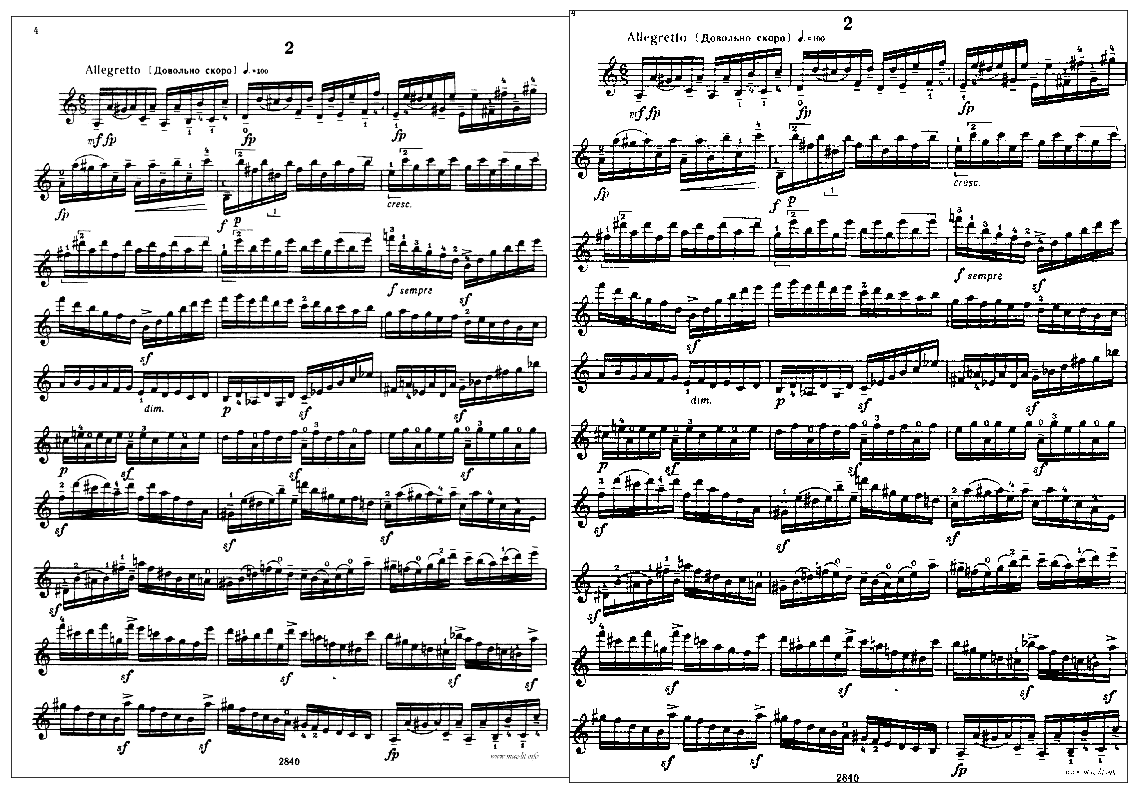

In [2]:
def crop_image(img,tol=0):
    # img is image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def rotate_image(mat, angle):
    # angle in degrees

    height, width = mat.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h), borderValue=255)
    return rotated_mat


# Reading the file
note_path = 'note2.png'
note = cv2.imread(note_path, 0)
note = cv2.medianBlur(note, 3)

# Filter out the gray stuff, custom step
ret, thresh = cv2.threshold(note, 127, 255, cv2.THRESH_BINARY)
thresh = 255 - crop_image(255 - thresh, 0)

# Find dominant angle
note_edges = cv2.Canny(thresh, 100, 200, None, 3)
lines = cv2.HoughLines(255 - thresh, 1, np.pi / 180, int(thresh.shape[1] * 0.6))
assert lines is not None
thetas = lines[:, 0, 1]
thetas_std = np.std(thetas)
thetas_mean = np.mean(thetas)
thetas = thetas[(thetas_mean - thetas_std - 1e-4 < thetas) &
                (thetas < thetas_mean + thetas_std + 1e-4)]
dominant_angle = np.median(thetas)

# Rotate image to the right alignment
angle_diff = (dominant_angle - np.pi / 2) * 180 / np.pi
thresh = rotate_image(thresh, angle_diff)
thresh = 255 - crop_image(255 - thresh, 0)
dominant_angle += angle_diff

# Visualization
f, axes = plt.subplots(1, 2, figsize=(20, 16))
axes[0].imshow(note, 'gray')
axes[1].imshow(thresh, 'gray')
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
for item in axes:
    item.set_xticks([])
    item.set_yticks([])

# Outline the most important variables
GLOBAL['note'] = thresh
GLOBAL['dominant_angle'] = dominant_angle

# Stage 2: Remove Thick Lines
I don't know why but the Violin notes usually contains weird thick lines. To correctly identify note heads (without using and pattern matching or neural networks, cause it will require training a model on a dataset, and I am lazy as hell), we need to filter out these weird lines.

## Steps:
1. Using 3x1 kernel to morph the heck out of the horizontal lines
2. The same with vertical lines using 1x3 kernel
3. Filter the remaining stuff by area

## Sensitive hyperparameters to be tuned
- Area threshold of the region to be considered as weird thick line (set at `2000`)
- Number of iterations for the morphology operations (set as `2` for the last and `3` for the rest)

## Export values:
- `GLOBAL['note_nobrows']` - a binary image of the violin sheet without weird thick lines

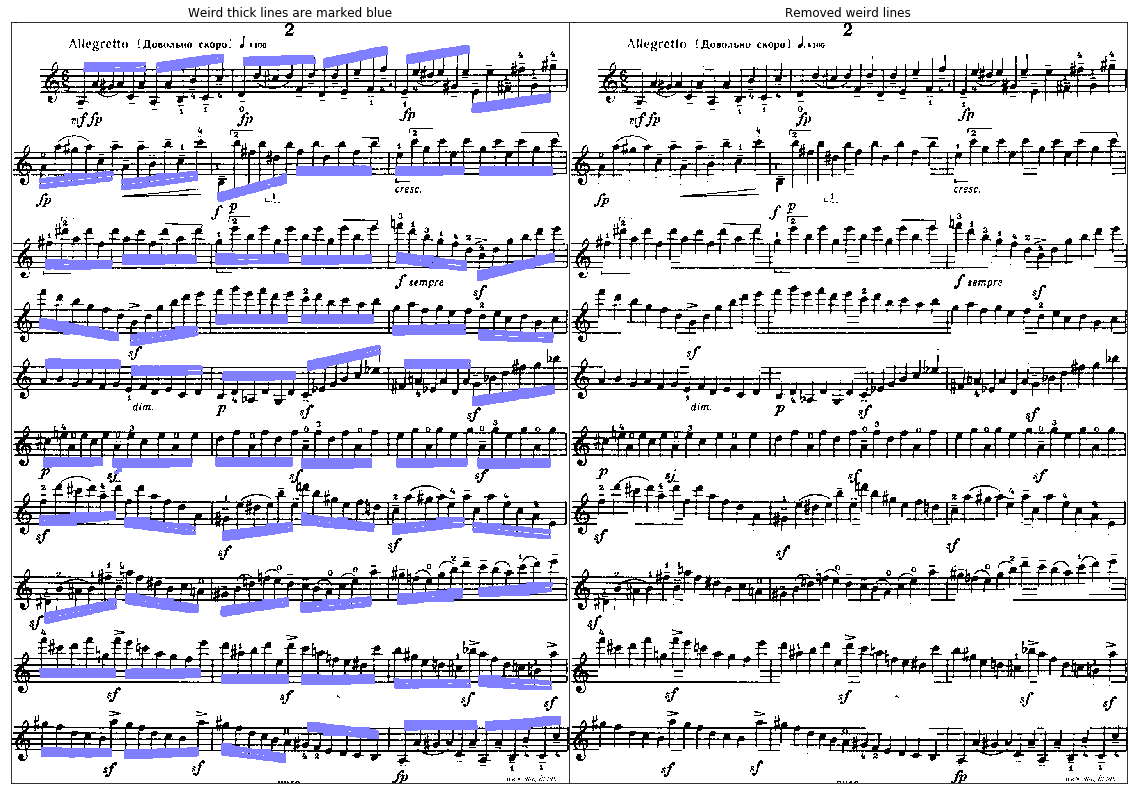

In [3]:
# Making copies to not mess up with the original
note_nobrows = GLOBAL['note'].copy()
note_visualization = cv2.cvtColor(note_nobrows, cv2.COLOR_GRAY2BGR)

# First, morph to delete thin vertical and horizontal stuff
kernel_delhor = np.ones((3, 1), np.uint8)
kernel_delver = np.ones((1, 3), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
morphed = 255 - note_nobrows
morphed = cv2.erode(morphed, kernel_delhor, iterations=3)
morphed = cv2.dilate(morphed, kernel_delhor, iterations=3)
morphed = cv2.erode(morphed, kernel_delver, iterations=3)
morphed = cv2.dilate(morphed, kernel_delver, iterations=3)
morphed = cv2.dilate(morphed, kernel3, iterations=2)

# Remove thicc lines
brows_mask = np.zeros(morphed.shape, dtype=np.uint8)
ret, morphed_markers = cv2.connectedComponents(morphed)
unique, counts = np.unique(morphed_markers, return_counts=True)
areas = np.concatenate((unique[1:, np.newaxis], counts[1:, np.newaxis]), axis=1)
areas = areas[areas[:, 1] > 2000]
bool_mask = np.isin(morphed_markers, areas[:, 0])
brows_mask[bool_mask] = 255
brows_mask = cv2.dilate(brows_mask, kernel3, iterations=0)
note_visualization[brows_mask != 0] = np.array([127, 127, 255])
note_nobrows[brows_mask != 0] = 255

# Visualization
f, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 14))
axes[0].set_title('Weird thick lines are marked blue')
axes[0].imshow(note_visualization, 'gray')
axes[1].set_title('Removed weird lines')
axes[1].imshow(note_nobrows, 'gray')
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
for item in axes:
    item.set_xticks([])
    item.set_yticks([])

# Conclusion
GLOBAL['note_nobrows'] = note_nobrows

# Stage 3: Detecting lines and bands
Please note that I have no musical education and I don't know the proper terminology. I call a *line* as... basically a line, and a *band* as a group of 5 lines. Knowing the dominant angle, we can filter out the lines that has roughly the same angle (with some error set at `1e-2`), and filter out the ones that are too close to each other. Then, we calculate the distance between lines in the band and the distance between bands.

## Steps:
1. Find lines from `GLOBAL['note']`. We don't use `GLOBAL['note_nobrows']` here for the reason that it may erase too much useful information about the lines. After some trials and errors, I made a decision to use the original sheet instead (the sheet without thick lines will be used for note head detection)
2. Each line is characterized by its `rho` (distance from origin) and `theta` (angle) values
3. Consider only lines that has `| theta - GLOBAL['dominant_angle'] | < 1e-2` 
3. Group the lines that are too close to each other (with `| rho_i - rho_j < linewidth_threshold |` ) and replace them with a single line with the averaged `rho`

## Sensitive hyperparameters to be tuned
- Percentage of horizontal blob to be considered as line (set at `80%`)
- `linewidth_threshold` (set at `7px`) - the distance difference which two lines will be considered as the same

## Export values:
- `GLOBAL['inband_dist']` - array of distances between lines in the bands
- `GLOBAL['exband_dist']` - array of distances between bands
- `GLOBAL['lines']` - array of lines, with shape `[n, 1, 2]`, where the last channel contains `rho` and `theta`
- `GLOBAL['bands']` - array of bands, with shape `[n, 1, 3]`, where the last channel contains `rho`, `theta` and `thickness`

in-band range: 13.0 ... 17.0
ex-band range: 88.0 ... 178.0
number of bands: 10
before filtering lines: 50  lines
after filtering proper lines: 50  lines


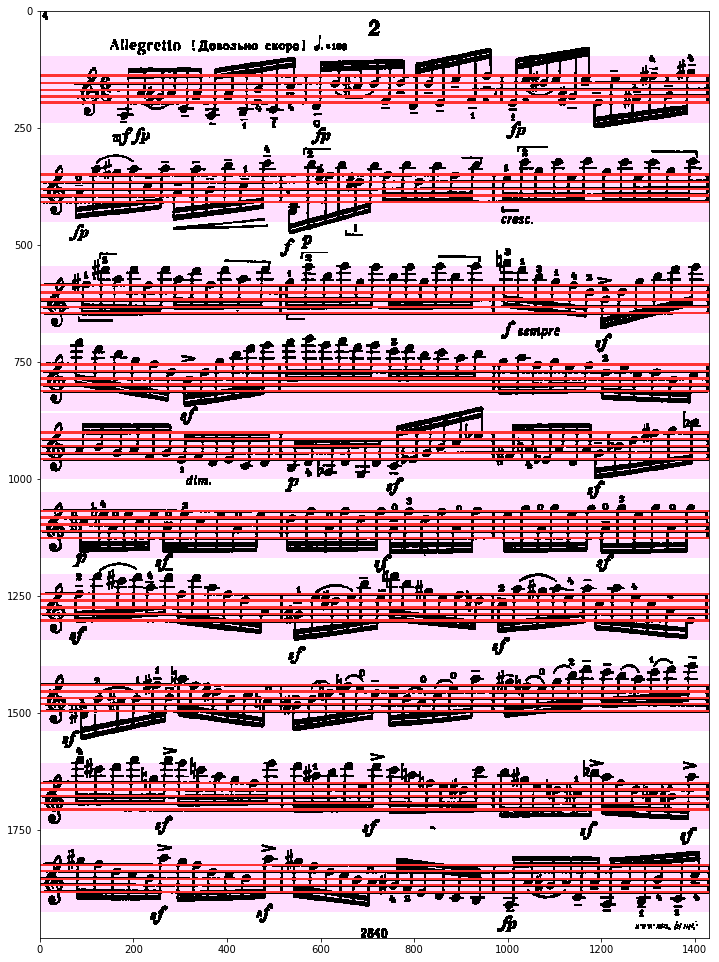

In [4]:
# Making copy
note = GLOBAL['note'].copy()
note_negative = 255 - note
kernel3 = np.ones((3, 3), dtype=np.uint8)
note_negative = cv2.dilate(note_negative, kernel3, iterations=1)
note = 255 - note_negative

# Detect edges
note_edges = 255 - note #cv2.Canny(note, 100, 200, None, 3)

def display_line(img, rho, theta, thicc=3, color=(0, 0, 0)):
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 3000*(-b)), int(y0 + 3000*(a)))
    pt2 = (int(x0 - 3000*(-b)), int(y0 - 3000*(a)))
    cv2.line(img, pt1, pt2, color, thicc)
    
# Copy of image
whites = np.ones((note.shape[0], note.shape[1], 3), dtype=np.uint8) * 255

# Find lines from edges
lines = cv2.HoughLines(255 - note, 1, np.pi / 180, int(note.shape[1] * 0.8))
assert lines is not None

# Predominant angle
dominant_angle = GLOBAL['dominant_angle']

# Filter out lines that does not match the dominant direction
thetas = lines[:, 0, 1]
lines = lines[(dominant_angle - 1e-2 < thetas) &
              (thetas < dominant_angle + 1e-2)]

# Sort the lines by rho value
rhos = lines[:, 0, 0]
args = np.argsort(rhos)
lines = lines[args, :, :]

# Visualize lines and the dominant direction
rho = whites.shape[0] // 2
theta = dominant_angle
display_line(whites, rho, theta, 15, (0, 255, 0))
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    display_line(whites, rho, theta, 3, (0, 0, 255))

# Filter out the lines that are too close to each other
linewidth_threshold = 7
proper_lines = []
lines_pool = []
prev_rho = None
for i in range(len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    if prev_rho is None:
        prev_dst = 1000000
    else:
        prev_dst = abs(rho - prev_rho)
    if len(lines_pool) != 0:
        if prev_dst > linewidth_threshold:
            avg_rho = np.round(np.mean(np.array(lines_pool)[:, 0]))
            avg_theta = np.mean(np.array(lines_pool)[:, 1])
            proper_lines.append([avg_rho, avg_theta])
            lines_pool = []
    prev_rho = rho
    lines_pool.append([rho, theta])

avg_rho = np.mean(np.array(lines_pool)[:, 0])
avg_theta = np.mean(np.array(lines_pool)[:, 1])
proper_lines.append([avg_rho, avg_theta])
proper_lines = np.array(proper_lines)[:, np.newaxis, :]

# Find the bands
rho_cp = proper_lines[:, 0, 0].copy()
rho_le = np.concatenate((np.zeros((1)), rho_cp))
rho_ri = np.concatenate((rho_cp, np.zeros((1))))
rho_dt = rho_le - rho_ri
rho_dt = np.abs(rho_dt[1:-1])
rho_inband_min = np.min(rho_dt)
rho_exband_max = np.max(rho_dt)
rho_inband_max = rho_inband_min
rho_exband_min = rho_exband_max
rho_inband_vals = []
rho_exband_vals = []
for rho in rho_dt:
    if abs(rho - rho_inband_max) < abs(rho - rho_exband_min):
        rho_inband_max = max(rho, rho_inband_max)
        rho_inband_vals.append(rho)
    else:
        rho_exband_min = min(rho, rho_exband_min)
        rho_exband_vals.append(rho)
print('in-band range:', rho_inband_min, '...', rho_inband_max)
print('ex-band range:', rho_exband_min, '...', rho_exband_max)
band_list = []
band_pool = []
prev_rho = None
for i in range(len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    if prev_rho is not None:
        if abs(rho - prev_rho) <= rho_inband_max:
            None
        if abs(rho - prev_rho) >= rho_exband_min:
            band_pool = np.array(band_pool)
            band_list.append([
                np.round(np.mean(band_pool[:, 0])),
                np.mean(band_pool[:, 1]),
                abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
            band_pool = []
    band_pool.append([rho, theta])
    prev_rho = rho
band_pool = np.array(band_pool)
band_list.append([
    np.round(np.mean(band_pool[:, 0])),
    np.mean(band_pool[:, 1]),
    abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
band_list = np.array(band_list)[:, np.newaxis, :]
print('number of bands:', band_list.shape[0])

# Visualize the proper lines
print('before filtering lines:', lines.shape[0], ' lines')
print('after filtering proper lines:', proper_lines.shape[0], ' lines')
bgr_thresh = cv2.cvtColor(note, cv2.COLOR_GRAY2BGR)
white_lines = np.ones(bgr_thresh.shape, dtype=np.uint8) * 0
white_bands = np.ones(bgr_thresh.shape, dtype=np.uint8) * 255
for i in range(0, len(band_list)):
    rho = band_list[i][0][0]
    theta = band_list[i][0][1]
    thicc = band_list[i][0][2]
    display_line(white_bands, rho, theta, int(thicc + rho_exband_min - 5), (255, 222, 255))
for i in range(0, len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    display_line(bgr_thresh, rho, theta, 3, (255, 50, 50))
bgr_thresh = np.minimum(bgr_thresh, white_bands)

# Visualization
plt.figure(figsize=(12, 20))
plt.imshow(bgr_thresh)
"""
f, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 14))
axes[0].imshow(whites, 'gray')
axes[1].imshow(bgr_thresh, 'gray')
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
for item in axes:
    item.set_xticks([])
    item.set_yticks([])
"""

GLOBAL['inband_dist'] = np.array(rho_inband_vals)
GLOBAL['exband_dist'] = np.array(rho_exband_vals)
GLOBAL['lines'] = proper_lines
GLOBAL['bands'] = band_list

# Stage 4: Detect Note Heads
Detect note heads and assign a unique value to each of the note heads. The weird symbol at the beginning (again, I don't know musical terminology) is an occlusion and will be removed later by a certain threshold.

## Steps:
1. Morphological operations on `GLOBAL['note_nobrows']` (earlier removed thick lines as occlusions)
2. Performing distance transformation (DT) and consider sure note heads as the pixels having DT value larger than some threshold
3. Do some watershed

## Sensitive hyperparameters to be tuned
- DT threshold (set at `70%`)

## Export values
- `GLOBAL['notehead_markers']` - Unique value for each note head pixels. Background is indexed as `1`
- `GLOBAL['notehead_centers']` - Centers of the markers

finding noteheads: 100%|##########| 378/378 [00:02<00:00, 130.80it/s]


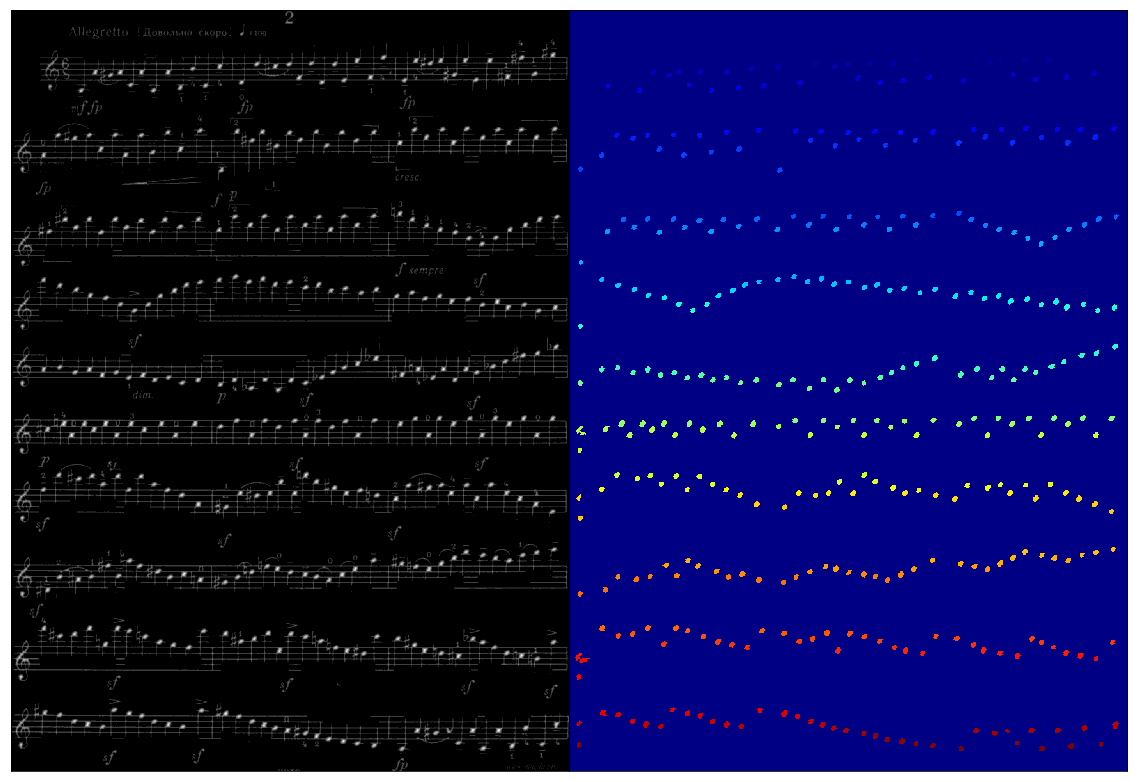

In [5]:
# Negative band
nobrows = GLOBAL['note_nobrows'].copy()
nobrows_negative = 255 - nobrows

# Erode a bit
kernel3 = np.ones((3, 3), np.uint8) 
opening = cv2.morphologyEx(nobrows_negative, cv2.MORPH_OPEN, kernel3, iterations=2)

# Find sure background
sure_bg = cv2.dilate(opening, kernel3, iterations=1)

# Find pixels that surely belogns to notes
dist_transform = cv2.distanceTransform(nobrows_negative, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Watershed
markers = cv2.watershed(cv2.cvtColor(nobrows, cv2.COLOR_GRAY2BGR), markers)

# Now, store the center for each marker
marker_count = int(np.max(markers) + 1)
marker_centers = np.zeros((marker_count, 2), dtype=np.int_)
for i in tqdm(range(2, marker_count), ascii=True, desc="finding noteheads"):
    coords = np.where(markers == i)
    marker_centers[i, 0] = np.round(np.sum(coords[0]) / coords[0].shape[0])
    marker_centers[i, 1] = np.round(np.sum(coords[1]) / coords[1].shape[0])

# Visualization
f, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 14))
axes[0].imshow(dist_transform, 'gray')
axes[1].imshow(markers, 'jet')
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
for item in axes:
    item.set_xticks([])
    item.set_yticks([])

# Export values
GLOBAL['notehead_markers'] = markers
GLOBAL['notehead_centers'] = marker_centers

# Stage 5: Assign Notes to Bands
For each note head, find a band that it belongs to. It is quite tricky, since a note can be closer to the band lower but is actually belonging to the band higher, so just looking at distances between bands and note heads *will not* work. We need informations about the vertical lines attached to note heads.

## Steps:
1. Remove horizontal lines by applying morphology magic with 3x1 kernel
2. Find connected components
3. Map the previous `GLOBAL['notehead_centers']` to the map of connected components
4. The sticks will always point the note head to the band it belongs to

## Sensitive hyperparameters to be tuned
- Number of iterations for the morphology operations (set as `3`)

## Export Value
- `GLOBAL['note2band']` - maps note id to band id
- `GLOBAL['bandstop']` - top most coordinate of bands notes or lines
- `GLOBAL['bandsbottom']` - bottom most coordinate of bands notes or lines
- `GLOBAL['notes_only']` - markers for notes with the sticks

assigning notes: 100%|##########| 378/378 [00:03<00:00, 116.86it/s]


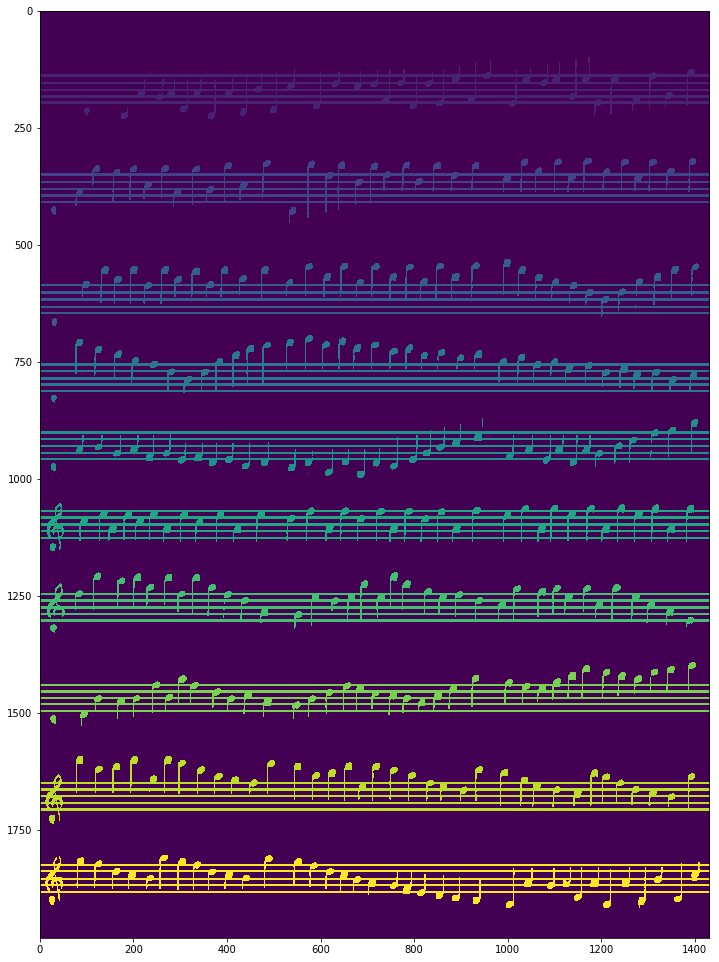

In [6]:
# Getting necessary variables
note_nobrows = GLOBAL['note_nobrows']
note_centers = GLOBAL['notehead_centers']
bands = GLOBAL['bands']
lines = GLOBAL['lines']

# Remove horizontal
kernel_delhor = np.ones((3, 1), np.uint8)
kernel_delver = np.ones((1, 3), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
morphed = 255 - note_nobrows
morphed = cv2.erode(morphed, kernel_delhor, iterations=3)
morphed = cv2.dilate(morphed, kernel_delhor, iterations=3)
morphed = 255 - morphed
ret, markers = cv2.connectedComponents(255 - morphed)

# Map note centers to markers
mapping = np.zeros((note_centers.shape[0]), dtype=np.int_)
centers_x = note_centers[:, 1]
centers_y = note_centers[:, 0]
mapping = markers[centers_y, centers_x]

# Create new color map
notes_only = np.ones(markers.shape, np.int_) * -1
for i in range(2, note_centers.shape[0]):
    notes_only[markers == mapping[i]] = i

# For each note, calculate its center and assign to band
def display_line(img, rho, theta, thicc=3, color=(0, 0, 0)):
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 3000*(-b)), int(y0 + 3000*(a)))
    pt2 = (int(x0 - 3000*(-b)), int(y0 - 3000*(a)))
    img = cv2.line(img, pt1, pt2, color, thicc)
    return img

note2band = np.ones((note_centers.shape[0]), dtype=np.int_) * -1
for i in tqdm(range(2, note_centers.shape[0]), ascii=True, desc='assigning notes'):
    y, x = np.where(notes_only == i)
    if y.shape[0] == 0:
        continue
    top, bottom = np.min(y), np.max(y)
    mid = (bottom + top) // 2
    note2band[i] = np.argmin(np.abs(bands[:, 0, 0] - mid))

bandsvis = np.zeros(markers.shape, np.uint8)
for bandid in range(bands.shape[0]):
    bandlines = lines[bandid * 5:bandid * 5 + 5, :, :]
    for i in range(bandlines.shape[0]):
        rho = bandlines[i, 0, 0]
        theta = bandlines[i, 0, 1]
        bandsvis = display_line(bandsvis, rho, theta, 3, bandid + 1)
for i in range(2, note_centers.shape[0]):
    if note2band[i] != -1:
        bandsvis[notes_only==i] = note2band[i] + 1

bandstop = np.zeros(bands.shape[0], np.int_)
bandsbottom = np.zeros(bands.shape[0], np.int_)
for bandid in range(bands.shape[0]):
    y, x = np.where(bandsvis==bandid+1)
    if y.shape[0] == 0:
        continue
    bandstop[bandid] = np.min(y)
    bandsbottom[bandid] = np.max(y)
        
# Visualization
plt.figure(figsize=(12, 20))
plt.imshow(bandsvis)

# Export values
GLOBAL['note2band'] = note2band
GLOBAL['bandstop'] = bandstop
GLOBAL['bandsbottom'] = bandsbottom
GLOBAL['notes_only'] = notes_only

# Stage 6: Recognize and Colorize
Recognize notes and colorize them accordingly.


## Choose a colormap:

In [16]:
# Rainbow Colormap
rainbow = [
    (255, 0, 0),
    (255, 127, 0),
    (255, 255, 0),
    (0, 255, 0),
    (0, 0, 255),
    (75, 0, 130),
    (148, 0, 211)
]

# v2 colormap
v2 = [
    (0x1f, 0x77, 0xb4),
    (0xff, 0x7f, 0x0e),
    (0x94, 0x67, 0xbd),
    (0x8c, 0x56, 0x4b),
    (0xe3, 0x77, 0xc2),
    (0xbc, 0xbd, 0x22),
    (0x17, 0xbe, 0xcf)
]

# Set colormap to use
GLOBAL['colormap'] = rainbow

## Sensitive hyperparameters to be tuned
- Size of the strange symbol called *clef* at the beginning (set as `50px`)
- Colorization top and bottom margin (set as `15px` and `15px`)
- Width of the brush (set as `35px`)

## Export value
- `GLOBAL['result']` - Colorization result. Can be saved to file (recommended)

colorizing notes: 100%|##########| 378/378 [00:03<00:00, 116.18it/s]


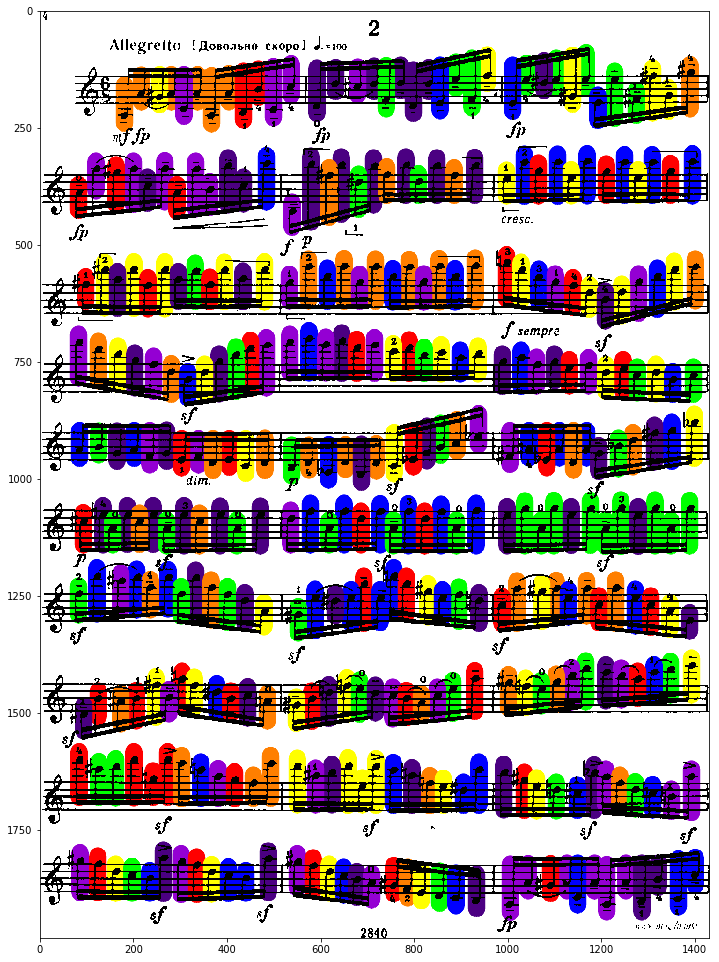

In [17]:
# Getting necessary data
bandstop = GLOBAL['bandstop']
bandsbottom = GLOBAL['bandsbottom']
note_centers = GLOBAL['notehead_centers']
note2band = GLOBAL['note2band']
lines = GLOBAL['lines']
notes_only = GLOBAL['notes_only']
note_copy = GLOBAL['note']
note_colored = cv2.cvtColor(note_copy, cv2.COLOR_GRAY2BGR)

# Color map
colormap = GLOBAL['colormap']

# How many bands?
band_counter = bandstop.shape[0]

# Just working
def process_band(startx, band_lines, band_note_centers):
    rho_top = band_lines[0, 0, 0].astype(np.float_)
    rho_bot = band_lines[-1, 0, 0].astype(np.float_)
    assert rho_bot > rho_top
    assert band_lines.shape[0] == 5
    rho_diff = (rho_bot - rho_top) / 9.
    band_note_y = band_note_centers[:, 0]
    band_note_x = band_note_centers[:, 1]
    note_names = np.round((band_note_y.astype(np.float_) - rho_top) / rho_diff).astype(np.int_)
    note_names[band_note_x < startx + 50] = -1000
    return note_names

note_names = np.ones(note_centers.shape[0], dtype=np.int_) * -1
for band_id in range(band_counter)[:]:
    assert bandsbottom[band_id] > bandstop[band_id]
    band_subim = 255 - note_copy[bandstop[band_id]:bandsbottom[band_id]+1, :]
    band_subim = band_subim.astype(np.int_)
    band_hist = np.sum(band_subim, axis=0)
    idx = np.where(band_hist > 0.3 * (bandsbottom[band_id] - bandstop[band_id]))
    startx = idx[0][0]
    band_sublines = lines[band_id*5:band_id*5+5]
    band_subnote_centers = note_centers[note2band==band_id]
    note_names[note2band==band_id] = process_band(startx, band_sublines, band_subnote_centers)
    note_names[note_names > -1000] = note_names[note_names > -1000] % 7 + 1

# Colorize
note_colorized = np.ones(note_colored.shape, dtype=np.uint8) * 255
for i in tqdm(range(2, note_centers.shape[0]), ascii=True, desc='colorizing notes'):
    if note_names[i] == -1:
        continue
    y, x = np.where(notes_only==i)
    if y.shape[0] == 0:
        continue
    top, bottom = np.min(y), np.max(y)
    left, right = np.min(x), np.max(x)
    top -= 10
    bottom += 10
    mid = (left + right) // 2
    if note_names[i] < 0:
        continue
    color = colormap[note_names[i] - 1]
    cv2.line(note_colorized, (mid, top), (mid, bottom), color, 35, cv2.LINE_AA)
note_colorized = np.minimum(note_colorized, note_colored)
    
# Visualization
plt.figure(figsize=(12, 20))
plt.imshow(note_colorized)

# Export values
GLOBAL['result'] = note_colorized

In [18]:
cv2.imwrite("note2_colorized.png", cv2.cvtColor(GLOBAL['result'], cv2.COLOR_RGB2BGR))

True